### This notebook generates charts to gauge the sensitivity of option prices to the binomial tree parameters

### Keep T and n the same for simplicity sake

In [1]:
import math
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons
import plotly.graph_objects as go
import pandas as pd
import datetime as dt
import warnings

In [2]:
# Settings the warnings to be ignored 
warnings.filterwarnings('ignore') 

%matplotlib ipympl

# Using sigma

### Eurpoean Calls and Puts

In [3]:
def binomial_tree_european_call(S, K, r, sigma, T, N):
    """
    Calculates the price of a European call option using a multi-step binomial tree.

    Parameters:
        S (float): initial stock price
        K (float): strike price
        r (float): risk-free interest rate
        sigma (float): stock price volatility
        T (float): time to maturity (in years)
        N (int): number of time steps in the binomial tree

    Returns:
        (float) price of the call option
    """
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u                             # Cox-Ross-Rubinstein formulation
    p = (np.exp(r * dt) - d) / (u - d)    # Risk neutral probability of going up, this needs to be between 0 and 1

    # Generate the stock price tree
    stock_tree = np.zeros((N+1, N+1))
    for i in range(N+1):                  # Loops through the columns
        for j in range(i+1):              # Loop through the rows
            stock_tree[j, i] = S * (u ** (i-j)) * (d ** j)    # Initial stock price multiplied by up amount (power of number of times it went up) multiplied by down amount (power of number of time it went down)

    # Print the stock price tree
    # print("Stock price tree:")
    # print(stock_tree)

    # Generate the option value tree
    option_tree = np.zeros((N+1, N+1))
    option_tree[:, N] = np.maximum(stock_tree[:, N] - K, 0)       # Payoff at maturity
    for i in range(N-1, -1, -1):          # Loops through the columns
        for j in range(i+1):              # Loop through the rows
            option_tree[j, i] = np.exp(-r * dt) * (p * option_tree[j, i+1] + (1-p) * option_tree[j+1, i+1])
            #option_tree[j, i] = max(option_tree[j, i], stock_tree[j, i] - K, 0)      # Do we need to add in a 0 here?

    # Print the option price tree
    # print("Option price tree:")
    # print(option_tree)

    return option_tree[0, 0]

In [4]:
def binomial_tree_european_put(S, K, r, sigma, T, N):
    """
    Calculates the price of a European put option using a multi-step binomial tree.

    Parameters:
        S (float): initial stock price
        K (float): strike price
        r (float): risk-free interest rate
        sigma (float): stock price volatility
        T (float): time to maturity (in years)
        N (int): number of time steps in the binomial tree

    Returns:
        (float) price of the put option
    """
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u                             # Cox-Ross-Rubinstein formulation
    p = (np.exp(r * dt) - d) / (u - d)    # Risk neutral probability of going up, this needs to be between 0 and 1

    # Generate the stock price tree
    stock_tree = np.zeros((N+1, N+1))
    for i in range(N+1):                  # Loops through the columns
        for j in range(i+1):              # Loop through the rows
            stock_tree[j, i] = S * (u ** (i-j)) * (d ** j)    # Initial stock price multiplied by up amount (power of number of times it went up) multiplied by down amount (power of number of time it went down)

    # Print the stock price tree
    #print("Stock price tree:")
    #print(stock_tree)

    # Generate the option value tree
    option_tree = np.zeros((N+1, N+1))
    option_tree[:, N] = np.maximum(K - stock_tree[:, N], 0)    # Payoff at maturity
    for i in range(N-1, -1, -1):          # Loops through the columns
        for j in range(i+1):              # Loop through the rows
            option_tree[j, i] = np.exp(-r * dt) * (p * option_tree[j, i+1] + (1-p) * option_tree[j+1, i+1])
            #option_tree[j, i] = max(option_tree[j, i], K - stock_tree[j, i], 0)    # Do we need to add in a 0 here?

    # Print the option price tree
    #print("Option price tree:")
    #print(option_tree)

    return option_tree[0, 0]

### American Calls and Puts

In [5]:
def binomial_tree_american_call(S, K, r, sigma, T, N):
    """
    Calculates the price of an American call option using a multi-step binomial tree.

    Parameters:
        S (float): initial stock price
        K (float): strike price
        r (float): risk-free interest rate
        sigma (float): stock price volatility
        T (float): time to maturity (in years)
        N (int): number of time steps in the binomial tree

    Returns:
        (float) price of the call option
    """
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u                              # Cox-Ross-Rubinstein formulation
    p = (np.exp(r * dt) - d) / (u - d)     # Risk neutral probability of going up, this needs to be between 0 and 1

    # Generate the stock price tree
    stock_tree = np.zeros((N+1, N+1))
    for i in range(N+1):                   # Loops through the columns
        for j in range(i+1):               # Loops through the rows
            stock_tree[j, i] = S * (u ** (i-j)) * (d ** j)   # Initial stock price multiplied by up amount (power of number of times it went up) multiplied by down amount (power of number of time it went down)

    # Print the stock price tree
    #print("Stock price tree:")
    #print(stock_tree)
    
    # Generate the option value tree
    option_tree = np.zeros((N+1, N+1))
    option_tree[:, N] = np.maximum(stock_tree[:, N] - K, 0)
    for i in range(N-1, -1, -1):           # Loops through the columns
        for j in range(i+1):               # Loops through the rows
            exercise_value = stock_tree[j, i] - K
            hold_value = np.exp(-r * dt) * (p * option_tree[j, i+1] + (1-p) * option_tree[j+1, i+1])
            option_tree[j, i] = max(exercise_value, hold_value, 0)

    # Print the option price tree
    #print("Option price tree:")
    #print(option_tree)
    
    return option_tree[0, 0]

In [6]:
def binomial_tree_american_put(S, K, r, sigma, T, N):
    """
    Calculates the price of an American put option using a multi-step binomial tree.

    Parameters:
        S (float): initial stock price
        K (float): strike price
        r (float): risk-free interest rate
        sigma (float): stock price volatility
        T (float): time to maturity (in years)
        N (int): number of time steps in the binomial tree

    Returns:
        (float) price of the put option
    """
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u                              # Cox-Ross-Rubinstein formulation
    p = (np.exp(r * dt) - d) / (u - d)     # Risk neutral probability of going up, this needs to be between 0 and 1

    # Generate the stock price tree
    stock_tree = np.zeros((N+1, N+1))
    for i in range(N+1):                   # Loops through the columns
        for j in range(i+1):               # Loops through the rows
            stock_tree[j, i] = S * (u ** (i-j)) * (d ** j)   # Initial stock price multiplied by up amount (power of number of times it went up) multiplied by down amount (power of number of time it went down)

    # Print the stock price tree
    #print("Stock price tree:")
    #print(stock_tree)

    # Generate the option value tree
    option_tree = np.zeros((N+1, N+1))
    option_tree[:, N] = np.maximum(K - stock_tree[:, N], 0)
    for i in range(N-1, -1, -1):          # Loops through the columns
        for j in range(i+1):              # Loops through the rows
            exercise_value = K - stock_tree[j, i]
            hold_value = np.exp(-r * dt) * (p * option_tree[j, i+1] + (1-p) * option_tree[j+1, i+1])
            option_tree[j, i] = max(exercise_value, hold_value, 0)        # Do we need to add in a 0 here?

    # Print the option price tree
    #print("Option price tree:")
    #print(option_tree)

    return option_tree[0, 0]

In [7]:
def BinomialTree(model):
    # Initial parameters
    S_init = 100
    K_init = 100
    r_init = 0.05
    sigma_init = 0.2
    T_init = 1
    N_init = 1

    axis_color = 'skyblue'

    fig, ax = plt.subplots(figsize=(10, 6))
    fig.subplots_adjust(left=0.30, bottom=0.40)

    # Define the range for S
    S_range = np.linspace(50, 150, 100)
    prices = [model(S, K_init, r_init, sigma_init, T_init, N_init) for S in S_range]

    line, = ax.plot(S_range, prices, linewidth=2, color='red')
    ax.set_xlim([50, 150])
    ax.set_ylim([0, max(prices) * 1.1])
    ax.set_xlabel('Initial Underlying Price')
    ax.set_ylabel('Option Price')
    ax.set_title(f"{model.__name__} Option Price")

    # Slider definitions
    #S_slider_ax = fig.add_axes([0.25, 0.30, 0.65, 0.03], facecolor=axis_color)
    #S_slider = Slider(S_slider_ax, 'Initial Stock Price', 50, 150, valinit=S_init)

    rf_slider_ax = fig.add_axes([0.25, 0.25, 0.65, 0.03], facecolor=axis_color)
    rf_slider = Slider(rf_slider_ax, 'Risk-free', 0.00, 0.10, valinit=r_init)

    time_slider_ax = fig.add_axes([0.25, 0.20, 0.65, 0.03], facecolor=axis_color)
    time_slider = Slider(time_slider_ax, 'Time', 0.1, 20, valinit=T_init)

    strike_slider_ax = fig.add_axes([0.25, 0.15, 0.65, 0.03], facecolor=axis_color)
    strike_slider = Slider(strike_slider_ax, 'Strike', 50, 150, valinit=K_init)

    sigma_slider_ax = fig.add_axes([0.25, 0.10, 0.65, 0.03], facecolor=axis_color)
    sigma_slider = Slider(sigma_slider_ax, 'Sigma', 0.1, 0.9, valinit=sigma_init)

    N_slider_ax = fig.add_axes([0.25, 0.05, 0.65, 0.03], facecolor=axis_color)
    N_slider = Slider(N_slider_ax, 'N', 1, 20, valinit=N_init)

    def sliders_on_changed(val):
        #S_current = S_slider.val
        K_current = strike_slider.val
        r_current = rf_slider.val
        sigma_current = sigma_slider.val
        T_current = time_slider.val
        N_current = int(N_slider.val)

        prices = [model(S, K_current, r_current, sigma_current, T_current, N_current) for S in S_range]
        line.set_ydata(prices)
        ax.set_ylim([0, max(prices) * 1.1])  # Adjust y-axis based on new data
        fig.canvas.draw_idle()

    #S_slider.on_changed(sliders_on_changed)
    rf_slider.on_changed(sliders_on_changed)
    time_slider.on_changed(sliders_on_changed)
    strike_slider.on_changed(sliders_on_changed)
    sigma_slider.on_changed(sliders_on_changed)
    N_slider.on_changed(sliders_on_changed)

    # Reset button
    reset_button_ax = fig.add_axes([0.8, 0.02, 0.1, 0.04])
    reset_button = Button(reset_button_ax, 'Reset', color=axis_color, hovercolor='0.975')
    def reset_button_on_clicked(mouse_event):
        #S_slider.reset()
        rf_slider.reset()
        time_slider.reset()
        strike_slider.reset()
        sigma_slider.reset()
        N_slider.reset()
    reset_button.on_clicked(reset_button_on_clicked)

    # Color radio buttons
    color_radios_ax = fig.add_axes([0.025, 0.5, 0.15, 0.15], facecolor=axis_color)
    color_radios = RadioButtons(color_radios_ax, ('red', 'blue', 'green'), active=0)
    def color_radios_on_clicked(label):
        line.set_color(label)
        fig.canvas.draw_idle()
    color_radios.on_clicked(color_radios_on_clicked)

    plt.show()

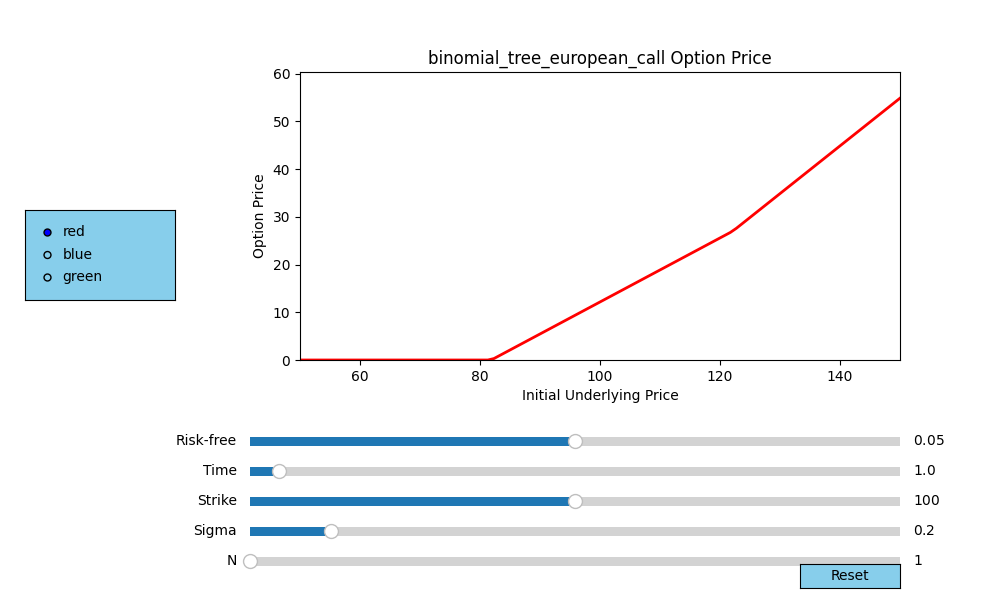

In [8]:
BinomialTree(binomial_tree_european_call)

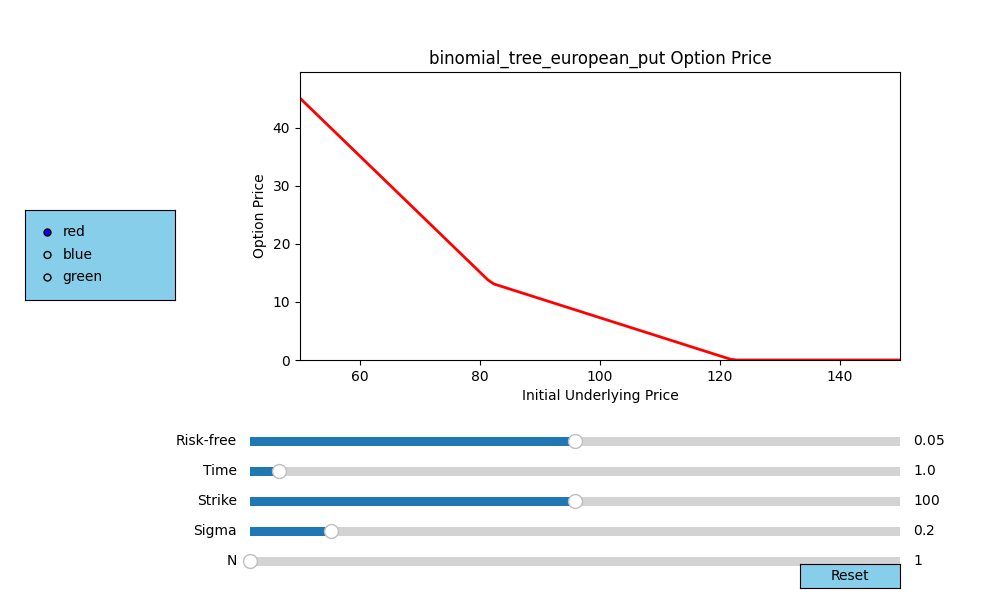

In [9]:
BinomialTree(binomial_tree_european_put)

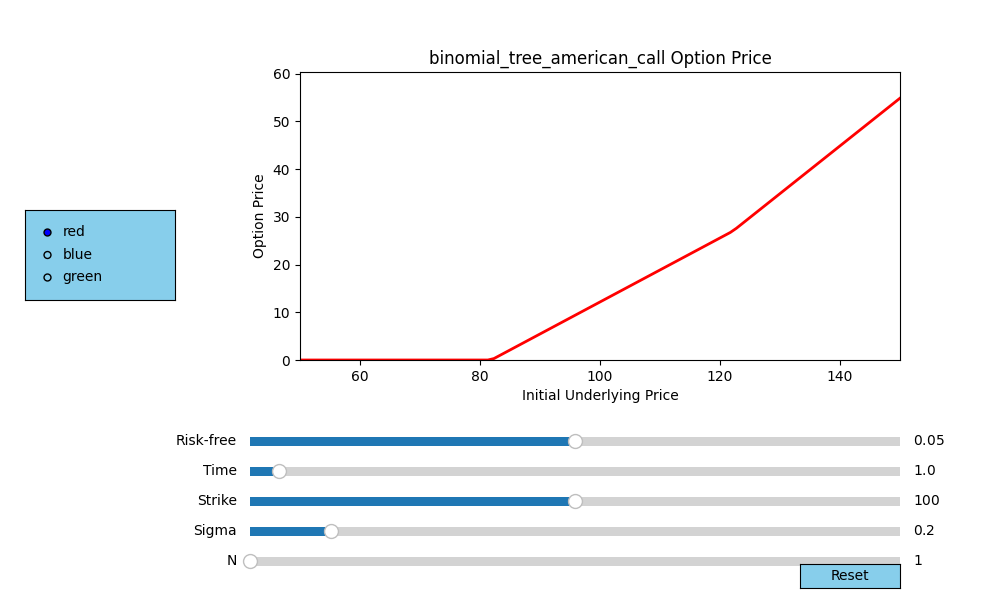

In [10]:
BinomialTree(binomial_tree_american_call)

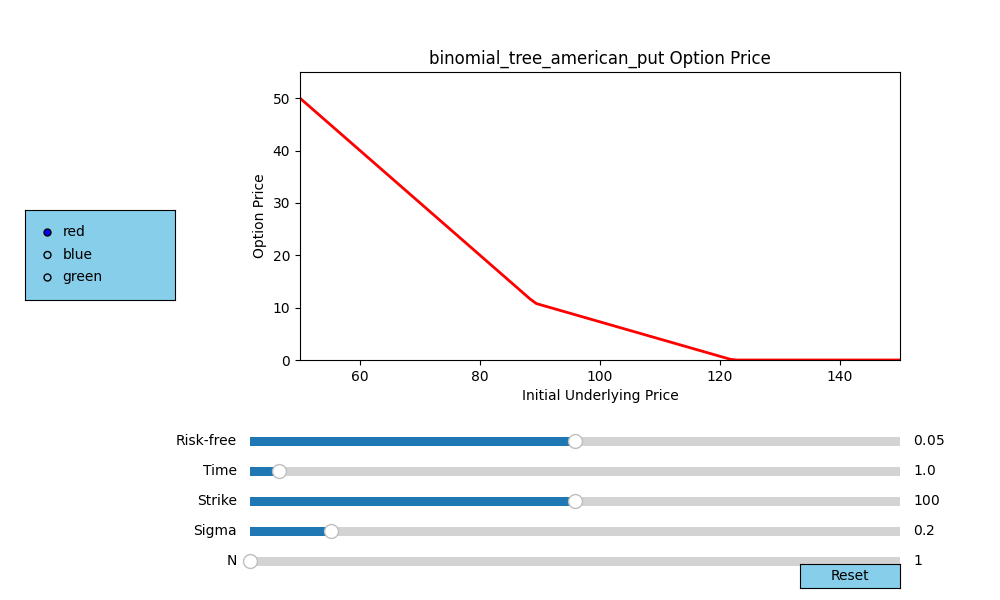

In [11]:
BinomialTree(binomial_tree_american_put)

# Using u/d

### Eurpoean Calls and Puts

In [12]:
def binomial_tree_basic_european_call(S, K, r, u, d, T, N):
    """
    Calculates the price of a European call option using a multi-step binomial tree.

    Parameters:
        S (float): initial stock price
        K (float): strike price
        r (float): risk-free interest rate
        u: Up factor
        d: Down factor
        T (float): time to maturity (in years)
        N (int): number of time steps in the binomial tree

    Returns:
        (float) price of the put option
    """
    dt=T/N
    # Compute the risk-neutral probabilities of moving up and down
    p = (((1+r)**dt) - d) / (u - d)          # Check this
    q = 1 - p
    
    #print(p)
    #print(q)

    # Generate the stock price tree
    stock_tree = np.zeros((N+1, N+1))
    for i in range(N+1):                  # Loops through the columns
        for j in range(i+1):              # Loop through the rows
            stock_tree[j, i] = S * (u ** (i-j)) * (d ** j)    # Initial stock price multiplied by up amount (power of number of times it went up) multiplied by down amount (power of number of time it went down)

    # Print the stock price tree
    #print("Stock price tree:")
    #print(stock_tree)

    # Generate the option value tree
    option_tree = np.zeros((N+1, N+1))
    option_tree[:, N] = np.maximum(stock_tree[:, N] - K, 0)    # Payoff at maturity
    for i in range(N-1, -1, -1):          # Loops through the columns
        for j in range(i+1):              # Loop through the rows
            option_tree[j, i] = (1/((1+r)**dt)) * (p * option_tree[j, i+1] + (1-p) * option_tree[j+1, i+1])    # Check this
            #option_tree[j, i] = max(option_tree[j, i], K - stock_tree[j, i], 0)    # Do we need to add in a 0 here?

    # Print the option price tree
    #print("Option price tree:")
    #print(option_tree)

    return option_tree[0, 0]

In [13]:
def binomial_tree_basic_european_put(S, K, r, u, d, T, N):
    """
    Calculates the price of a European put option using a multi-step binomial tree.

    Parameters:
        S (float): initial stock price
        K (float): strike price
        r (float): risk-free interest rate
        u: Up factor
        d: Down factor
        T (float): time to maturity (in years)
        N (int): number of time steps in the binomial tree

    Returns:
        (float) price of the put option
    """
    dt=T/N
    # Compute the risk-neutral probabilities of moving up and down
    p = (((1+r)**dt) - d) / (u - d)         # Check this
    q = 1 - p
    
    #print(p)
    #print(q)

    # Generate the stock price tree
    stock_tree = np.zeros((N+1, N+1))
    for i in range(N+1):                  # Loops through the columns
        for j in range(i+1):              # Loop through the rows
            stock_tree[j, i] = S * (u ** (i-j)) * (d ** j)    # Initial stock price multiplied by up amount (power of number of times it went up) multiplied by down amount (power of number of time it went down)

    # Print the stock price tree
    #print("Stock price tree:")
    #print(stock_tree)

    # Generate the option value tree
    option_tree = np.zeros((N+1, N+1))
    option_tree[:, N] = np.maximum(K - stock_tree[:, N], 0)    # Payoff at maturity
    for i in range(N-1, -1, -1):          # Loops through the columns
        for j in range(i+1):              # Loop through the rows
            option_tree[j, i] = (1/((1+r)**dt)) * (p * option_tree[j, i+1] + (1-p) * option_tree[j+1, i+1])    # Check this
            #option_tree[j, i] = max(option_tree[j, i], K - stock_tree[j, i], 0)    # Do we need to add in a 0 here?

    # Print the option price tree
    #print("Option price tree:")
    #print(option_tree)

    return option_tree[0, 0]

### Basic American Calls and Puts

In [14]:
def binomial_tree_basic_american_call(S, K, r, u, d, T, N):
    """
    Calculates the price of an American call option using a multi-step binomial tree.

    Parameters:
        S (float): initial stock price
        K (float): strike price
        r (float): risk-free interest rate
        u: Up factor
        d: Down factor
        T (float): time to maturity (in years)
        N (int): number of time steps in the binomial tree

    Returns:
        (float) price of the put option
    """
    dt=T/N
    # Compute the risk-neutral probabilities of moving up and down
    p = (((1+r)**dt) - d) / (u - d)      # Check this
    q = 1 - p
    
    #print(p)
    #print(q)
    
    # Generate the stock price tree
    stock_tree = np.zeros((N+1, N+1))
    for i in range(N+1):                   # Loops through the columns
        for j in range(i+1):               # Loops through the rows
            stock_tree[j, i] = S * (u ** (i-j)) * (d ** j)   # Initial stock price multiplied by up amount (power of number of times it went up) multiplied by down amount (power of number of time it went down)

    # Print the stock price tree
    #print("Stock price tree:")
    #print(stock_tree)

    # Generate the option value tree
    option_tree = np.zeros((N+1, N+1))
    option_tree[:, N] = np.maximum(stock_tree[:, N] - K, 0)
    for i in range(N-1, -1, -1):          # Loops through the columns
        for j in range(i+1):              # Loops through the rows
            exercise_value = stock_tree[j, i] - K
            hold_value = (1/((1+r)** dt)) * (p * option_tree[j, i+1] + (1-p) * option_tree[j+1, i+1])   # Check this
            option_tree[j, i] = max(exercise_value, hold_value, 0)        # Do we need to add in a 0 here?

    # Print the option price tree
    #print("Option price tree:")
    #print(option_tree)

    return option_tree[0, 0]

In [15]:
def binomial_tree_basic_american_put(S, K, r, u, d, T, N):
    """
    Calculates the price of an American put option using a multi-step binomial tree.

    Parameters:
        S (float): initial stock price
        K (float): strike price
        r (float): risk-free interest rate
        u: Up factor
        d: Down factor
        T (float): time to maturity (in years)
        N (int): number of time steps in the binomial tree

    Returns:
        (float) price of the put option
    """
    dt=T/N
    # Compute the risk-neutral probabilities of moving up and down
    p = (((1+r)**dt) - d) / (u - d)          # Check this
    q = 1 - p
    
    #print(p)
    #print(q)
    
    # Generate the stock price tree
    stock_tree = np.zeros((N+1, N+1))
    for i in range(N+1):                   # Loops through the columns
        for j in range(i+1):               # Loops through the rows
            stock_tree[j, i] = S * (u ** (i-j)) * (d ** j)   # Initial stock price multiplied by up amount (power of number of times it went up) multiplied by down amount (power of number of time it went down)

    # Print the stock price tree
    #print("Stock price tree:")
    #print(stock_tree)

    # Generate the option value tree
    option_tree = np.zeros((N+1, N+1))
    option_tree[:, N] = np.maximum(K - stock_tree[:, N], 0)
    for i in range(N-1, -1, -1):          # Loops through the columns
        for j in range(i+1):              # Loops through the rows
            exercise_value = K - stock_tree[j, i]
            hold_value = (1/((1+r)** dt)) * (p * option_tree[j, i+1] + (1-p) * option_tree[j+1, i+1])   # Check this
            option_tree[j, i] = max(exercise_value, hold_value, 0)        # Do we need to add in a 0 here?

    # Print the option price tree
    #print("Option price tree:")
    #print(option_tree)

    return option_tree[0, 0]

In [16]:
def BasicBinomialTree(model):
    # Initial parameters
    S_init = 100
    K_init = 100
    r_init = 0.05
    u_init = 2
    d_init= 0.5
    T_init = 1
    N_init = 1

    axis_color = 'skyblue'

    fig, ax = plt.subplots(figsize=(10, 6))
    fig.subplots_adjust(left=0.30, bottom=0.40)

    # Define the range for S
    S_range = np.linspace(50, 150, 100)
    prices = [model(S, K_init, r_init, u_init, d_init, T_init, N_init) for S in S_range]

    line, = ax.plot(S_range, prices, linewidth=2, color='red')
    ax.set_xlim([50, 150])
    ax.set_ylim([0, max(prices) * 1.1])
    ax.set_xlabel('Initial Underlying Price')
    ax.set_ylabel('Option Price')
    ax.set_title(f"{model.__name__} Option Price")

    # Slider definitions
    #S_slider_ax = fig.add_axes([0.25, 0.30, 0.65, 0.03], facecolor=axis_color)
    #S_slider = Slider(S_slider_ax, 'Initial Stock Price', 50, 150, valinit=S_init)

    rf_slider_ax = fig.add_axes([0.25, 0.30, 0.65, 0.03], facecolor=axis_color)
    rf_slider = Slider(rf_slider_ax, 'Risk-free', 0.00, 0.50, valinit=r_init)

    time_slider_ax = fig.add_axes([0.25, 0.25, 0.65, 0.03], facecolor=axis_color)
    time_slider = Slider(time_slider_ax, 'Time', 0.1, 20, valinit=T_init)

    strike_slider_ax = fig.add_axes([0.25, 0.20, 0.65, 0.03], facecolor=axis_color)
    strike_slider = Slider(strike_slider_ax, 'Strike', 50, 150, valinit=K_init)

    u_slider_ax = fig.add_axes([0.25, 0.15, 0.65, 0.03], facecolor=axis_color)
    u_slider = Slider(u_slider_ax, 'Up Factor', 1.0, 5.0, valinit=u_init)
    
    d_slider_ax = fig.add_axes([0.25, 0.10, 0.65, 0.03], facecolor=axis_color)
    d_slider = Slider(d_slider_ax, 'Down Factor', 0.1, 1.0, valinit=d_init)

    N_slider_ax = fig.add_axes([0.25, 0.05, 0.65, 0.03], facecolor=axis_color)
    N_slider = Slider(N_slider_ax, 'N', 1, 20, valinit=N_init)

    def sliders_on_changed(val):
        #S_current = S_slider.val
        K_current = strike_slider.val
        r_current = rf_slider.val
        u_current = u_slider.val
        d_current = d_slider.val
        T_current = time_slider.val
        N_current = int(N_slider.val)

        prices = [model(S, K_current, r_current, u_current, d_current, T_current, N_current) for S in S_range]
        line.set_ydata(prices)
        ax.set_ylim([0, max(prices) * 1.1])  # Adjust y-axis based on new data
        fig.canvas.draw_idle()

    #S_slider.on_changed(sliders_on_changed)
    rf_slider.on_changed(sliders_on_changed)
    time_slider.on_changed(sliders_on_changed)
    strike_slider.on_changed(sliders_on_changed)
    u_slider.on_changed(sliders_on_changed)
    d_slider.on_changed(sliders_on_changed)
    N_slider.on_changed(sliders_on_changed)

    # Reset button
    reset_button_ax = fig.add_axes([0.025, 0.02, 0.1, 0.04])
    reset_button = Button(reset_button_ax, 'Reset', color=axis_color, hovercolor='0.975')
    def reset_button_on_clicked(mouse_event):
        #S_slider.reset()
        rf_slider.reset()
        time_slider.reset()
        strike_slider.reset()
        u_slider.reset()
        d_slider.reset()
        N_slider.reset()
    reset_button.on_clicked(reset_button_on_clicked)

    # Color radio buttons
    color_radios_ax = fig.add_axes([0.025, 0.5, 0.15, 0.15], facecolor=axis_color)
    color_radios = RadioButtons(color_radios_ax, ('red', 'blue', 'green'), active=0)
    def color_radios_on_clicked(label):
        line.set_color(label)
        fig.canvas.draw_idle()
    color_radios.on_clicked(color_radios_on_clicked)

    plt.show()

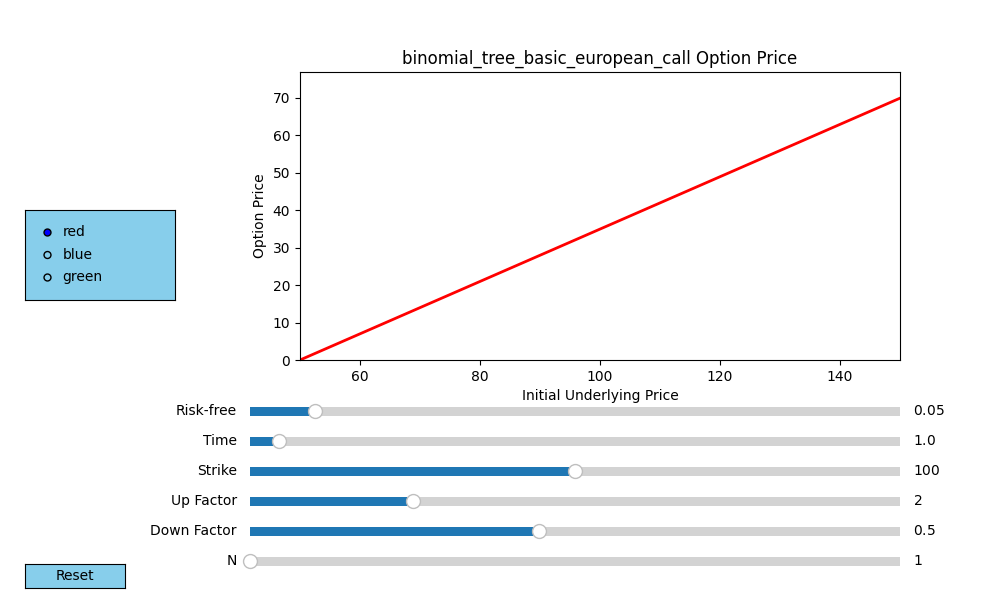

In [17]:
BasicBinomialTree(binomial_tree_basic_european_call)

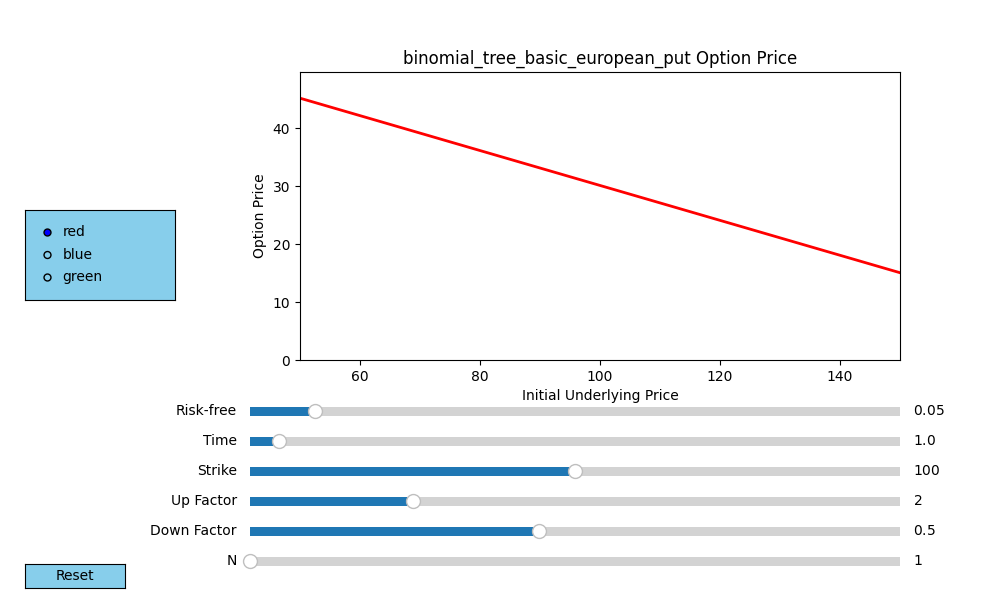

In [18]:
BasicBinomialTree(binomial_tree_basic_european_put)

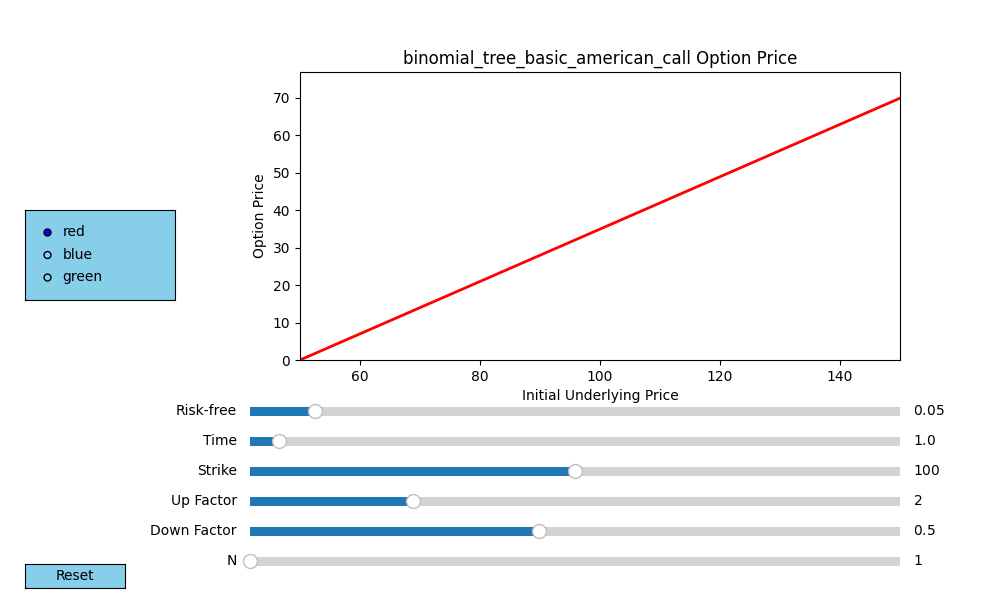

In [19]:
BasicBinomialTree(binomial_tree_basic_american_call)

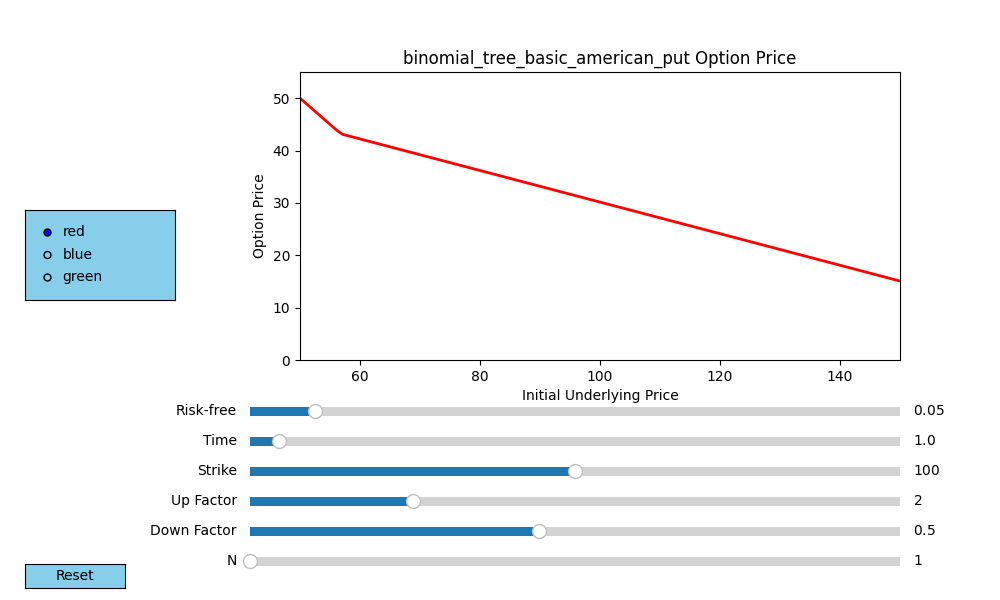

In [20]:
BasicBinomialTree(binomial_tree_basic_american_put)